In [1]:
import h5py    
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage.filters import uniform_filter1d
from scipy.interpolate import interp1d
from IPython.display import clear_output
import multiprocessing as mp
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
# figsize(10,8)



/home/rccheng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import h5py as h5
l1 = h5.File('./data/CFIS_L1_NGDCS20170619t184335_cal_2018_v2.h5','r')
spectra_ = np.array(l1['camera/radiances'][:])
wlSize=2048
disp = np.asarray([-1.2553e-6,0.0201,735.4572])
ind = np.linspace(1,wlSize,wlSize)
wlGrid_ = np.polyval(disp,ind )
wlGrid = wlGrid_[(wlGrid_>747)&(wlGrid_<756)]
spectra_ = spectra_[:,(wlGrid_>747)&(wlGrid_<756),:]
l1.close()



In [3]:
# Read in tabulated pre-computed dataset.
sun = np.loadtxt('data/solar_merged_20160127_600_26316_100.out')
# interpolate to common grid in wavelength (not wavenumber), use 0.002nm sampling here
res = 0.002
# create wavelength grid in nm
wl = np.arange(727,776,res)
# Solar transmission spectrum, resample to wavelength grid (from wavenumber):
f = interp1d(1.e7/sun[:,0], sun[:,1])
Tsun = f(wl)
co = 2.355
T_cfis = gaussian_filter1d(Tsun, 0.07/res/co)




In [4]:
wl.shape

(24500,)

In [5]:
f1 = h5py.File('./data/PS_SIF_map_easy.h5','r')    
f1_keys=list(f1.keys())
list(f1.keys())
SIF_shape_ = f1['SIF_shape'][:] # (437,)

wl_sif = f1['wlGrid'][:] # dwlGrid = 0.03 (437,)
f = interp1d(wl_sif,SIF_shape_,fill_value="extrapolate")
SIF_shape = f(wlGrid)
f1.close()

In [6]:
co = 2.355


class Setup:
    pass
mySetup = Setup()

mySetup.FWHM = 0.07
# wo = np.where((wl_solarSpectrum>743)&(wl_solarSpectrum<757))[0]
# mySetup.wl_so = wl

mySetup.wl_in = wl
mySetup.wl_out = wlGrid
mySetup.res = 0.01 # wlGrid[1:]-wlGrid[0:-1]




In [7]:
# reference solar spectrum
# Lo = Tsun*s_base/np.pi # mW/M2/SR/UM
Tsun = T_cfis.copy()
Lo = Tsun/np.pi 

In [62]:

# def forward_model_shift(x,b,compK = False):
#     poly_wl = x[0:3]
#     ## add FWHM into state vector
# #     b.FWHM = x[3]
#     b.FWHM = 0.07
#     poly = x[-4:-1]

#     a = x[-1]
# #     c1 = x[0]; p0 = x[1]; p1 = x[2]; p2 = x[3]; a = x[4]
    

#     Lo_conv = gaussian_filter1d(Lo,b.FWHM/b.res/co)
    
#     detPixels = len(b.wl_in)
#     grid = np.arange(0,detPixels,1)-detPixels/2.
# #     wl_shifted = grid+c1 # b.nu_out in the example 8
#     wl_shifted = np.polyval(poly_wl,grid)
    
#     finter1 = interp1d(grid, Lo_conv,kind='linear', fill_value=np.NaN,bounds_error=False)
#     Lo_conv_shifted = finter1(wl_shifted)
    
#     finter2 = interp1d(b.wl_in, Lo_conv_shifted,kind='linear', fill_value=np.NaN,bounds_error=False)
#     Lo_1 = finter2(b.wl_out)# output Lo
    
#     dwl = b.wl_out-np.mean(b.wl_out)
#     F_ref_nosif = Lo_1*np.polyval(poly,dwl)
#     F_forward = F_ref_nosif+a*SIF_shape

#     if compK:
#         K = np.zeros((len(b.wl_out),len(x)))
# #         dx = [5e-6,5e-6,5e-6]
#         dx = [1e-6,1e-6,1e-6,1e-6]
#         for i in range(3):
#             poly_wl2 = poly_wl.copy()
#             poly_wl2[i] = poly_wl[i]+dx[i]
# #             c1_2 = c1 + dx
#             Lo_2 = finter1(np.polyval(poly_wl2,grid))
#             finter3 = interp1d(b.wl_in, Lo_2,kind='linear', fill_value=np.NaN,bounds_error=False)
#             Lo_2 = finter3(b.wl_out)
#             FF = Lo_2*np.polyval(poly,dwl)+a*SIF_shape

#             K[:,i] = (FF-F_forward)/dx[i]# partial I partial c1
        
#         K[:,-4] = Lo_1*dwl**2 # partial I partial p0
        
#         K[:,-3] = Lo_1*dwl# partial I partial p1
#         K[:,-2] = Lo_1# partial I partial p2
#         K[:,-1] = SIF_shape# partial I partial a
#         ## add FWHM into state vector
# #         FWHM2 = b.FWHM+dx[3]
# #         Lo_conv2 = gaussian_filter1d(Lo,FWHM2/b.res/co)
    
# #         finter1_2 = interp1d(grid, Lo_conv2,kind='linear', fill_value=np.NaN,bounds_error=False)
# #         Lo_conv_shifted_2 = finter1_2(wl_shifted)

# #         finter2_2 = interp1d(b.wl_in, Lo_conv_shifted_2,kind='linear', fill_value=np.NaN,bounds_error=False)
# #         Lo_1_2 = finter2_2(b.wl_out)# output Lo

# #         F_ref_nosif_2 = Lo_1_2*np.polyval(poly,dwl)
# #         F_forward_2 = F_ref_nosif_2+a*SIF_shape
# #         K[:,3] = (F_forward_2-F_forward)/dx[3]
#     if compK:
#         return F_forward,K
#     else:
#         return F_forward


# def iterate_fit(x0,b,F,n_itr=500,thrs = 1e-3):
#     chi2_r_old = 1e9
#     DOF = len(F)-len(x0)
#     invSe = noise_model(F)
#     F0_guess,K = forward_model_shift(x0,b,compK=True)
#     Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
#     x = x0+ Gain.dot(F-F0_guess)
#     F0,K = forward_model_shift(x,b,compK=True)
#     chi2 = np.sum((F0-F0_guess)**2*np.diag(invSe))
#     chi2_r = chi2/DOF
#     print(xa)
#     chi2_r_itr =[];x_linear_itr=[];sif_1sigma_itr=[]
#     for i in range(n_itr):
        
        
# #         #F0,K = forward_model_shift(x,b,compK=True)
# # #         #### uncomment the below if no prior
# #         Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
        
# #         x_plus1 = x+ Gain.dot(F-F0)
# #         ####
        
#         ####
# # #         add prior
#         x_plus1 = x + np.linalg.inv(K.T.dot(invSe).dot(K)+invSa).dot(K.T.dot(invSe).dot(F-F0)-invSa.dot(x-xa))
#         print(x_plus1.shape)
#         ####
#         S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
# #         print('1 sigma FWHM')
#         print(np.sqrt(S_posterior[3,3]))
#         sif_1sigma = np.sqrt(S_posterior[-1,-1])
#         #F2 = forward_model_shift(x_plus1,b)
#         F2,K_new = forward_model_shift(x_plus1,b,compK=True)
#         chi2 = np.sum((F2-F)**2*np.diag(invSe))
#         chi2_r = chi2/DOF
#         chi2_r_itr.append(chi2_r)
#         x_linear_itr.append(x_plus1)
#         sif_1sigma_itr.append(sif_1sigma)
#         if abs(chi2_r-chi2_r_old) < thrs:
#             print('iteration %d' %i)
#             break
#         else:
#             x = x_plus1.copy() 
#             chi2_r_old = chi2_r.copy()
#             F0 = F2.copy()
#             K = K_new.copy()
            
        
#     return x_linear_itr,sif_1sigma_itr,chi2_r_itr



# def noise_model(F):
# # '''This is the noise model for each point on the map'''
# # '''F is the measured radiance, which is a function of wavelength'''
    
#     invSe = np.zeros((len(F),len(F)))
    
#     noise = np.sqrt(F)/40
    
#     invSe=np.diag(1./(noise**2) )
#     return invSe


# def linear_fit(F):
#     invSe = noise_model(F)
#     Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
#     x_linear = Gain.dot(F)
#     S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
#     sif_1sigma = np.sqrt(S_posterior[-1,-1])
#     chi2 = np.sum((np.dot(K,x_linear)-F)**2*np.diag(invSe))
#     chi2_r = chi2/(len(F)-len(x_linear))
    
#     return x_linear,sif_1sigma,chi2_r

In [8]:
#### Add uniform filter (box)
def forward_model_shift(x,b,compK = False):
    poly_wl = x[0:3]
    b.FWHM_g = x[3]
    b.FWHM_b = int(x[4])
    poly = x[-4:-1]

    a = x[-1]
#     c1 = x[0]; p0 = x[1]; p1 = x[2]; p2 = x[3]; a = x[4]
    
    Lo_conv = uniform_filter1d(Lo,size = int(b.FWHM_b))
    Lo_conv = gaussian_filter1d(Lo_conv,b.FWHM_g/b.res/co)
 
    detPixels = len(b.wl_in)
    grid = np.arange(0,detPixels,1)-detPixels/2.
#     wl_shifted = grid+c1 # b.nu_out in the example 8
    wl_shifted = np.polyval(poly_wl,grid)
    
    finter1 = interp1d(grid, Lo_conv,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_conv_shifted = finter1(wl_shifted)
    
    finter2 = interp1d(b.wl_in, Lo_conv_shifted,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_1 = finter2(b.wl_out)# output Lo
    
    dwl = b.wl_out-np.mean(b.wl_out)
    F_ref_nosif = Lo_1*np.polyval(poly,dwl)
    F_forward = F_ref_nosif+a*SIF_shape

    if compK:
        K = np.zeros((len(b.wl_out),len(x)))
#         dx = [5e-6,5e-6,5e-6]
        dx = [1e-6,1e-6,1e-6,1e-6,10]
        for i in range(3):
            poly_wl2 = poly_wl.copy()
            poly_wl2[i] = poly_wl[i]+dx[i]
#             c1_2 = c1 + dx
            Lo_2 = finter1(np.polyval(poly_wl2,grid))
            finter3 = interp1d(b.wl_in, Lo_2,kind='linear', fill_value=np.NaN,bounds_error=False)
            Lo_2 = finter3(b.wl_out)
            FF = Lo_2*np.polyval(poly,dwl)+a*SIF_shape

            K[:,i] = (FF-F_forward)/dx[i]# partial I partial c1
        
        K[:,-4] = Lo_1*dwl**2 # partial I partial p0
        
        K[:,-3] = Lo_1*dwl# partial I partial p1
        K[:,-2] = Lo_1# partial I partial p2
        K[:,-1] = SIF_shape# partial I partial a
        
        FWHM2_g = b.FWHM_g+dx[3]
        Lo_conv2 = uniform_filter1d(Lo,size = b.FWHM_b)
        Lo_conv2 = gaussian_filter1d(Lo_conv2,FWHM2_g/b.res/co)
    
        finter1_2 = interp1d(grid, Lo_conv2,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_conv_shifted_2 = finter1_2(wl_shifted)

        finter2_2 = interp1d(b.wl_in, Lo_conv_shifted_2,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_1_2 = finter2_2(b.wl_out)# output Lo

        F_ref_nosif_2 = Lo_1_2*np.polyval(poly,dwl)
        F_forward_2 = F_ref_nosif_2+a*SIF_shape
        K[:,3] = (F_forward_2-F_forward)/dx[3]
        
        FWHM2_b = b.FWHM_b+dx[4]
        Lo_conv2 = uniform_filter1d(Lo,size = FWHM2_b)
        Lo_conv2 = gaussian_filter1d(Lo_conv2,b.FWHM_g/b.res/co)
    
        finter1_2 = interp1d(grid, Lo_conv2,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_conv_shifted_2 = finter1_2(wl_shifted)

        finter2_2 = interp1d(b.wl_in, Lo_conv_shifted_2,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_1_2 = finter2_2(b.wl_out)# output Lo

        F_ref_nosif_2 = Lo_1_2*np.polyval(poly,dwl)
        F_forward_2 = F_ref_nosif_2+a*SIF_shape
        KK = (F_forward_2-F_forward)/dx[3]
        K[:,4] = [int(k) for k in KK]
    if compK:
        return F_forward,K
    else:
        return F_forward


def iterate_fit(x0,b,F,n_itr=500,thrs = 1e-3):
    chi2_r_old = 1e9
    DOF = len(F)-len(x0)
    invSe = noise_model(F)
    F0_guess,K = forward_model_shift(x0,b,compK=True)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x = x0+ Gain.dot(F-F0_guess)
    F0,K = forward_model_shift(x,b,compK=True)
    chi2 = np.sum((F0-F0_guess)**2*np.diag(invSe))
    chi2_r = chi2/DOF
    print(xa)
    chi2_r_itr =[];x_linear_itr=[];sif_1sigma_itr=[]
    for i in range(n_itr):
        
        
#         #F0,K = forward_model_shift(x,b,compK=True)
#         #### uncomment the below if no prior
#         Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
        
#         x_plus1 = x+ Gain.dot(F-F0)
#         ####
        
        ####
# #         add prior
        x_plus1 = x + np.linalg.inv(K.T.dot(invSe).dot(K)+invSa).dot(K.T.dot(invSe).dot(F-F0)-invSa.dot(x-xa))
        print(x_plus1.shape)
        ####
        S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
        sif_1sigma = np.sqrt(S_posterior[-1,-1])
        #F2 = forward_model_shift(x_plus1,b)
        F2,K_new = forward_model_shift(x_plus1,b,compK=True)
        chi2 = np.sum((F2-F)**2*np.diag(invSe))
        chi2_r = chi2/DOF
        chi2_r_itr.append(chi2_r)
        x_linear_itr.append(x_plus1)
        sif_1sigma_itr.append(sif_1sigma)
        if abs(chi2_r-chi2_r_old) < thrs:
            print('iteration %d' %i)
            break
        else:
            x = x_plus1.copy() 
            chi2_r_old = chi2_r.copy()
            F0 = F2.copy()
            K = K_new.copy()
            
        
    return x_linear_itr,sif_1sigma_itr,chi2_r_itr



def noise_model(F):
# '''This is the noise model for each point on the map'''
# '''F is the measured radiance, which is a function of wavelength'''
    
    invSe = np.zeros((len(F),len(F)))
    
    noise = np.sqrt(F)/40
    
    invSe=np.diag(1./(noise**2) )
    return invSe


def linear_fit(F):
    invSe = noise_model(F)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x_linear = Gain.dot(F)
    S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
    sif_1sigma = np.sqrt(S_posterior[-1,-1])
    chi2 = np.sum((np.dot(K,x_linear)-F)**2*np.diag(invSe))
    chi2_r = chi2/(len(F)-len(x_linear))
    return x_linear,sif_1sigma,chi2_r

In [9]:
spectra = np.mean(spectra_[100,:,500:600],axis=-1)

In [10]:
# FWHM is not a state vector
# F_forward,K = forward_model_shift([0,1,40]+[0.2,0.28,233,0],mySetup,compK=True)
# only gaussian convolution
# F_forward,K = forward_model_shift([0,1,40,0.07]+[0.2,1.6,310,2.8],mySetup,compK=True)
## two layer convolution
F_forward,K = forward_model_shift([0,1,40,0.07,4]+[0.2,1.6,310,2.8],mySetup,compK=True)

x_linear,sif_1sigma,chi2_r = linear_fit(spectra)




Text(0.5,87,'wavelenght(nm)')

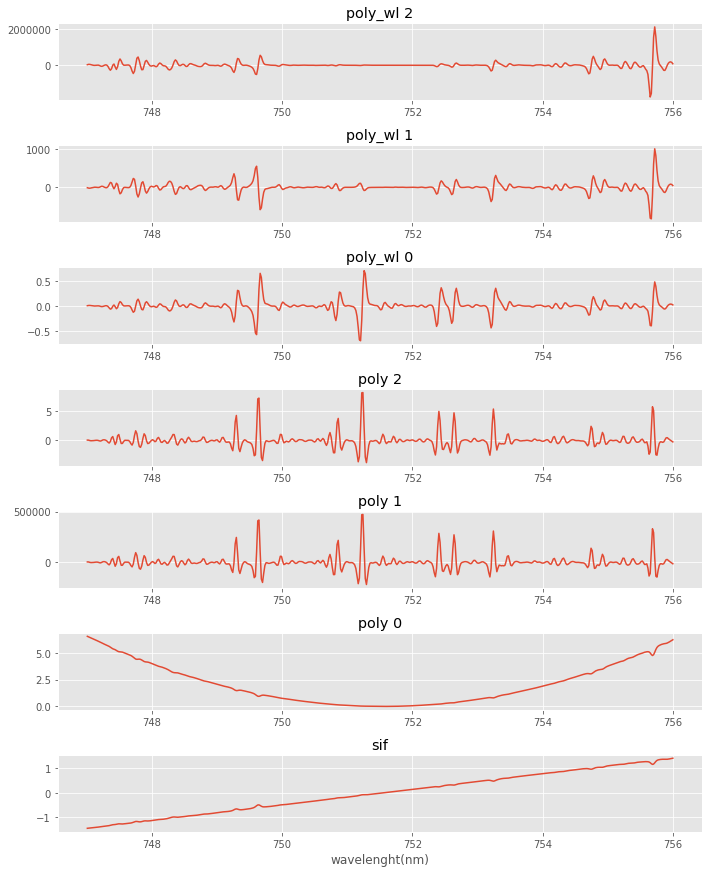

In [11]:
## FWHM is not a state vector
# poly_wl = x[0:3]
#     b.FWHM_g = x[3]
#     b.FWHM_b = x[4]
#     poly = x[-4:-1]
plt.figure(figsize=(10,12))
plt.subplot(7,1,1)
plt.plot(mySetup.wl_out,K[:,0])
plt.title('poly_wl 2')
plt.subplot(7,1,2)
plt.plot(mySetup.wl_out,K[:,1])
plt.title('poly_wl 1')
plt.subplot(7,1,3)
plt.plot(mySetup.wl_out,K[:,2])
plt.title('poly_wl 0')
plt.subplot(7,1,4)
plt.plot(mySetup.wl_out,K[:,3])
plt.title('poly 2')
plt.subplot(7,1,5)
plt.plot(mySetup.wl_out,K[:,4])
plt.title('poly 1')
plt.subplot(7,1,6)
plt.plot(mySetup.wl_out,K[:,5])
plt.title('poly 0')
plt.subplot(7,1,7)
plt.plot(mySetup.wl_out,K[:,6])
plt.title('sif')
plt.tight_layout()
plt.xlabel('wavelenght(nm)')

In [12]:
# only gaussian filter
# # poly_wl = x[0:3]
# #     b.FWHM_g = x[3]
# #     b.FWHM_b = x[4]
# #     poly = x[-4:-1]
# plt.figure(figsize=(10,12))
# plt.subplot(9,1,1)
# plt.plot(mySetup.wl_out,K[:,0])
# plt.title('poly_wl 2')
# plt.subplot(9,1,2)
# plt.plot(mySetup.wl_out,K[:,1])
# plt.title('poly_wl 1')
# plt.subplot(9,1,3)
# plt.plot(mySetup.wl_out,K[:,2])
# plt.title('poly_wl 0')
# plt.subplot(9,1,4)
# plt.plot(mySetup.wl_out,K[:,3])
# plt.title('FWHM gaussion')
# plt.subplot(9,1,5)
# # plt.plot(mySetup.wl_out,K[:,4])
# # plt.title('FWHM box')
# plt.subplot(9,1,6)
# plt.plot(mySetup.wl_out,K[:,4])
# plt.title('poly 2')
# plt.subplot(9,1,7)
# plt.plot(mySetup.wl_out,K[:,5])
# plt.title('poly 1')
# plt.subplot(9,1,8)
# plt.plot(mySetup.wl_out,K[:,6])
# plt.title('poly 0')
# plt.subplot(9,1,9)
# plt.plot(mySetup.wl_out,K[:,7])
# plt.title('sif')
# plt.tight_layout()
# plt.xlabel('wavelenght(nm)')

Text(0.5,87,'wavelenght(nm)')

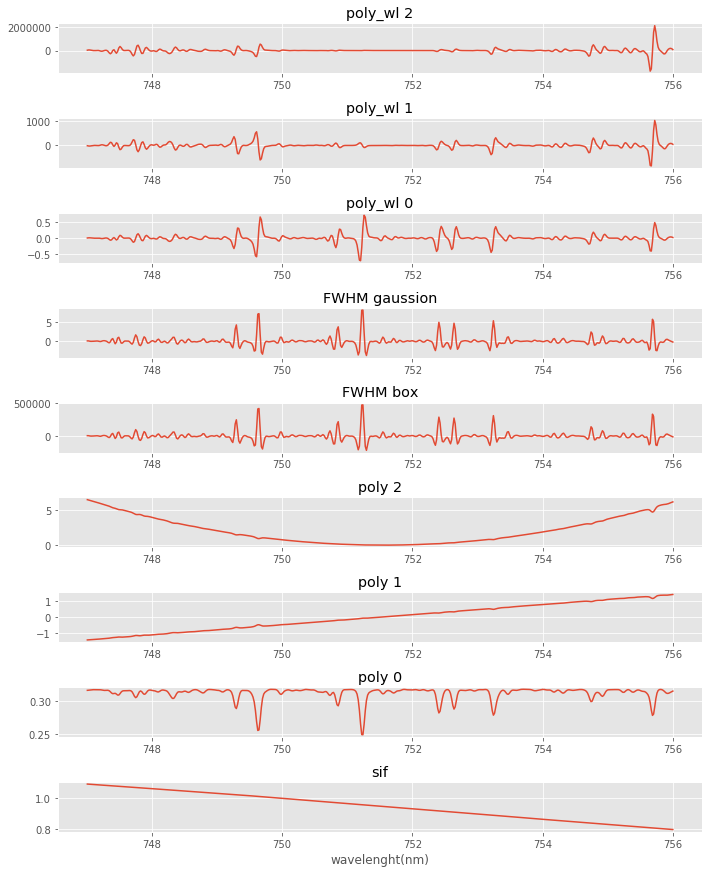

In [13]:
# poly_wl = x[0:3]
#     b.FWHM_g = x[3]
#     b.FWHM_b = x[4]
#     poly = x[-4:-1]
plt.figure(figsize=(10,12))
plt.subplot(9,1,1)
plt.plot(mySetup.wl_out,K[:,0])
plt.title('poly_wl 2')
plt.subplot(9,1,2)
plt.plot(mySetup.wl_out,K[:,1])
plt.title('poly_wl 1')
plt.subplot(9,1,3)
plt.plot(mySetup.wl_out,K[:,2])
plt.title('poly_wl 0')
plt.subplot(9,1,4)
plt.plot(mySetup.wl_out,K[:,3])
plt.title('FWHM gaussion')
plt.subplot(9,1,5)
plt.plot(mySetup.wl_out,K[:,4])
plt.title('FWHM box')
plt.subplot(9,1,6)
plt.plot(mySetup.wl_out,K[:,5])
plt.title('poly 2')
plt.subplot(9,1,7)
plt.plot(mySetup.wl_out,K[:,6])
plt.title('poly 1')
plt.subplot(9,1,8)
plt.plot(mySetup.wl_out,K[:,7])
plt.title('poly 0')
plt.subplot(9,1,9)
plt.plot(mySetup.wl_out,K[:,8])
plt.title('sif')
plt.tight_layout()
plt.xlabel('wavelenght(nm)')

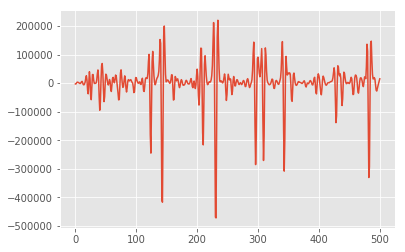

In [14]:
plt.plot(K[:,3]-K[:,4])

In [15]:
# ## FWHM is not a state vector
# xa =[0,0,0,0,0,0,x_linear[-1]] #[0,0,0,0,0,0,10]

# invSa = np.zeros((len(xa),len(xa)))
# invSa[-1,-1] = 1/(0.4**2)
# ##add prior info
# ## only gaussian filter
# xa =[0,0,0,0.07,0,0,0,x_linear[-1]] #[0,0,0,0,0,0,10]

# invSa = np.zeros((len(xa),len(xa)))


# invSa[3,3] = 1/(0.004**2)
# invSa[-1,-1] = 1/(0.1**2)

## two layers of filters
xa =[0,0,0,0.07,0,0,0,0,x_linear[-1]] #[0,0,0,0,0,0,10]

invSa = np.zeros((len(xa),len(xa)))


invSa[3,3] = 1/(0.008**2)
invSa[-1,-1] = 1/(0.1**2)

In [16]:
len(xa)

9

In [17]:
x_linear

array([ 2.17024785e-07, -3.83618346e-04, -7.42677584e+00,  1.16224290e+00,
       -1.71202377e-05,  1.20817307e-01,  4.28114860e-01,  2.29872837e+02,
        1.08901748e+00])

In [18]:
chi2_r

0.9150279136074977

In [20]:
# FWHM is not a state vector

# F_forward,K = forward_model_shift([0,1,31]+[0.06,0.32,229,1.5],mySetup,compK=True)
# only gaussian convolution
# F_forward,K = forward_model_shift([0,1,40,0.07]+[0.2,1.6,310,2.8],mySetup,compK=True)
## two layer convolution
F_forward,K = forward_model_shift([0,1,40,0.07,4]+[0.2,1.6,310,2.8],mySetup,compK=True)

x_linear,sif_1sigma,chi2_r = linear_fit(spectra)





Text(0.5,1,'linear retrievel one step')

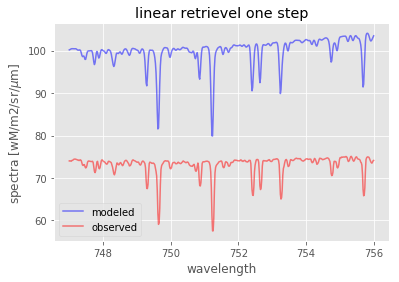

In [21]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('linear retrievel one step')

Text(0.5,1,'linear retrievel one step')

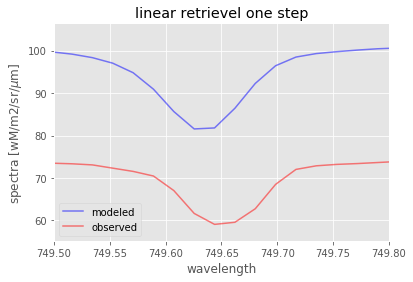

In [22]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.xlim((749.5,749.8))
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('linear retrievel one step')

Text(0.5,1,'linear retrievel one step')

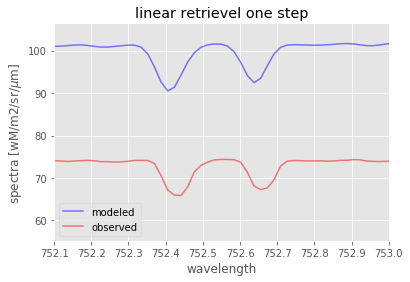

In [23]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.xlim((752.1,753))
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('linear retrievel one step')

Text(0.5,1,'F_forward-F_observed')

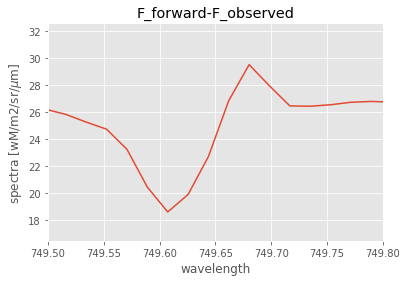

In [24]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlim((749.5,749.8))
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [26]:
# FWHM is not a state vector
# ma,mb,mc = iterate_fit([0,1,31.5]+[0.2,1.6,310,2.8],mySetup,spectra,n_itr=200,thrs=1e-10)
# # gaussian filter only
# ma,mb,mc = iterate_fit([0,1,40,0.07]+[0.2,1.6,310,2.8],mySetup,spectra,n_itr=200,thrs=1e-10)
## two layers of filters
ma,mb,mc = iterate_fit([0,1,40,0.07,4]+[0.2,1.6,310,2.8],mySetup,spectra,n_itr=200,thrs=1e-10)

[0, 0, 0, 0.07, 0, 0, 0, 0, 1.0890174755457167]
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9

In [27]:
len(ma)

200

In [28]:

np.array(ma)[:,-1]

array([1.36375694, 1.06629288, 1.06843143, 1.06838612, 1.06848825,
       1.06846339, 1.06845926, 1.0684615 , 1.06846069, 1.06846084,
       1.06846102, 1.06846103, 1.06846102, 1.06846103, 1.06846102,
       1.06846103, 1.06846102, 1.06846103, 1.06846102, 1.06846103,
       1.06846102, 1.06846103, 1.06846102, 1.06846103, 1.06846102,
       1.06846103, 1.06846102, 1.06846103, 1.06846102, 1.06846103,
       1.06846102, 1.06846103, 1.06846102, 1.06846103, 1.06846102,
       1.06846103, 1.06846102, 1.06846103, 1.06846102, 1.06846103,
       1.06846102, 1.06846103, 1.06846102, 1.06846103, 1.06846102,
       1.06846103, 1.06846102, 1.06846103, 1.06846102, 1.06846103,
       1.06846102, 1.06846103, 1.06846102, 1.06846103, 1.06846102,
       1.06846103, 1.06846102, 1.06846103, 1.06846102, 1.06846103,
       1.06846102, 1.06846103, 1.06846102, 1.06846103, 1.06846102,
       1.06846103, 1.06846102, 1.06846103, 1.06846102, 1.06846103,
       1.06846102, 1.06846103, 1.06846102, 1.06846103, 1.06846

In [29]:
mc

[8.475675751988973,
 1.7160994987823996,
 1.6603257614341604,
 1.6594882959489512,
 1.6594998287214826,
 1.6594998949213602,
 1.659489248535531,
 1.6594917213205975,
 1.6594906277294603,
 1.659490678317899,
 1.6594909706245842,
 1.6594909670981142,
 1.6594909518806844,
 1.659490967742065,
 1.6594909511025693,
 1.659490966850562,
 1.6594909507905902,
 1.6594909685415422,
 1.6594909501629367,
 1.6594909683162806,
 1.6594909513691005,
 1.659490968227772,
 1.659490950817035,
 1.6594909685460875,
 1.6594909510980433,
 1.659490967507787,
 1.6594909511252234,
 1.6594909673893539,
 1.6594909503272093,
 1.6594909681488577,
 1.6594909506024242,
 1.6594909671956881,
 1.6594909508895117,
 1.6594909688183206,
 1.659490951634611,
 1.6594909678339964,
 1.6594909512233162,
 1.6594909675698746,
 1.659490951361079,
 1.6594909678092724,
 1.6594909507463145,
 1.6594909677250211,
 1.6594909504573572,
 1.6594909684935517,
 1.6594909497723098,
 1.6594909677901122,
 1.6594909518350314,
 1.6594909680206706,
 1

In [30]:

np.array(ma)[:,3]

array([0.06970333, 0.07064552, 0.07075278, 0.07076243, 0.07076164,
       0.07076181, 0.07076184, 0.0707619 , 0.07076183, 0.07076182,
       0.07076186, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076185,
       0.07076185, 0.07076185, 0.07076185, 0.07076185, 0.07076

In [31]:
mb

[1.0599030531802094,
 0.44680932360151154,
 0.4464396580359651,
 0.4465263133088116,
 0.44649680012303755,
 0.44650055651948484,
 0.4464861471448573,
 0.4465023813638086,
 0.4464942782456749,
 0.44649940258902016,
 0.44650362751076855,
 0.4465037436249383,
 0.4465033538436285,
 0.4465037079203354,
 0.4465033778639589,
 0.44650372355582285,
 0.44650335482451153,
 0.44650371079611095,
 0.4465033676377321,
 0.4465037311973745,
 0.446503375498248,
 0.4465037468634243,
 0.44650335366587,
 0.4465037088365928,
 0.44650335943475383,
 0.4465037200737464,
 0.4465033640860645,
 0.44650373605521515,
 0.44650336644930305,
 0.4465037304772592,
 0.4465033782659523,
 0.44650374270023807,
 0.446503362438712,
 0.4465037178154979,
 0.4465033637889109,
 0.44650374144111954,
 0.44650334773726336,
 0.4465037155053117,
 0.44650335477130865,
 0.4465037326839823,
 0.4465033637190776,
 0.4465037446466718,
 0.44650335099638655,
 0.4465037294858416,
 0.4465033648646146,
 0.4465037273446398,
 0.4465033582138865,
 

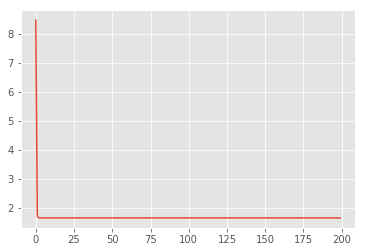

In [32]:
plt.plot(mc)

In [33]:
ma

[array([-1.78627730e-06,  1.00145690e+00,  2.71522356e+01,  6.97033279e-02,
         3.99986569e+00,  1.21714204e-01,  4.56940813e-01,  2.28932794e+02,
         1.36375694e+00]),
 array([2.81391001e-07, 9.99339247e-01, 3.04099020e+01, 7.06455208e-02,
        3.99986389e+00, 1.21021288e-01, 4.25132129e-01, 2.29941065e+02,
        1.06629288e+00]),
 array([2.41659718e-07, 9.99365489e-01, 2.99218673e+01, 7.07527767e-02,
        3.99986019e+00, 1.20889494e-01, 4.25896169e-01, 2.29934959e+02,
        1.06843143e+00]),
 array([2.41581305e-07, 9.99361733e-01, 2.99973028e+01, 7.07624266e-02,
        3.99985646e+00, 1.20902625e-01, 4.25832816e-01, 2.29935037e+02,
        1.06838612e+00]),
 array([2.45949320e-07, 9.99361140e-01, 2.99764415e+01, 7.07616400e-02,
        3.99985272e+00, 1.20896793e-01, 4.25843771e-01, 2.29934783e+02,
        1.06848825e+00]),
 array([2.45722477e-07, 9.99360237e-01, 2.99790051e+01, 7.07618125e-02,
        3.99984899e+00, 1.20897475e-01, 4.25840827e-01, 2.29934857e+0

In [34]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

Text(0.5,1,'non-linear retrievel last step')

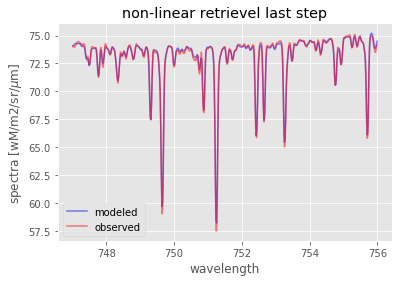

In [35]:

plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

Text(0.5,1,'F_forward-F_observed')

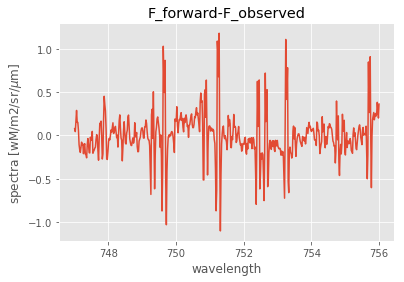

In [36]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [36]:
spectra2 =spectra_[220,:,550]
F_forward,K = forward_model_shift([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,compK=True)
x_linear,sif_1sigma,chi2_r = linear_fit(spectra2)
#add prior info
xa =[0,0,0,0.07]+list(x_linear[4:]) #[0,0,0,0,0,0,10]
invSa = np.zeros((len(xa),len(xa)))
invSa[3,3] = 1/(0.001**2)
invSa[-1,-1] = 1/(1**2)

LinAlgError: Singular matrix

Text(0.5,1,'non-linear retrievel last step')

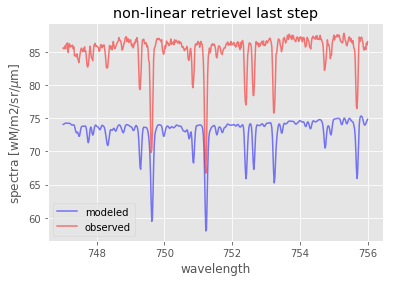

In [37]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra2,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

Text(0.5,1,'F_forward-F_observed')

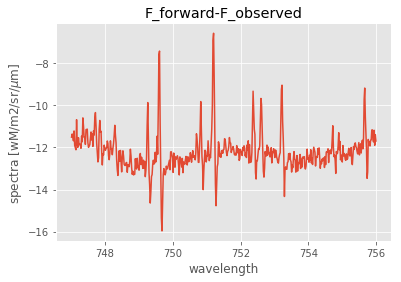

In [38]:
plt.plot(mySetup.wl_out,F_forward-spectra2)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [39]:

ma,mb,mc =iterate_fit([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,spectra2,n_itr=200,thrs=1e-10)

LinAlgError: Singular matrix

In [40]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

In [41]:
ma

[array([ 1.39086297e-07,  9.99452056e-01,  3.00570495e+01,  1.11662077e-01,
         1.92508325e-02,  2.41601712e+02, -2.76329895e+00]),
 array([ 1.34014599e-07,  9.99468815e-01,  3.00823343e+01,  1.11647022e-01,
         1.87414245e-02,  2.41616178e+02, -2.76806256e+00]),
 array([ 1.32577853e-07,  9.99469949e-01,  3.00835276e+01,  1.11645341e-01,
         1.86721819e-02,  2.41618244e+02, -2.76874292e+00]),
 array([ 1.32625984e-07,  9.99469915e-01,  3.00835191e+01,  1.11644598e-01,
         1.86429691e-02,  2.41619072e+02, -2.76901455e+00]),
 array([ 1.32622211e-07,  9.99469917e-01,  3.00835220e+01,  1.11644625e-01,
         1.86439910e-02,  2.41619043e+02, -2.76900509e+00]),
 array([ 1.32622384e-07,  9.99469917e-01,  3.00835219e+01,  1.11644623e-01,
         1.86439132e-02,  2.41619045e+02, -2.76900581e+00]),
 array([ 1.32622368e-07,  9.99469917e-01,  3.00835219e+01,  1.11644623e-01,
         1.86439169e-02,  2.41619045e+02, -2.76900578e+00]),
 array([ 1.32622358e-07,  9.99469917e-01,

In [42]:
np.array(ma)[:,-1]

array([-2.76329895, -2.76806256, -2.76874292, -2.76901455, -2.76900509,
       -2.76900581, -2.76900578, -2.76900578, -2.76900578, -2.76900578,
       -2.76900578, -2.76900578])

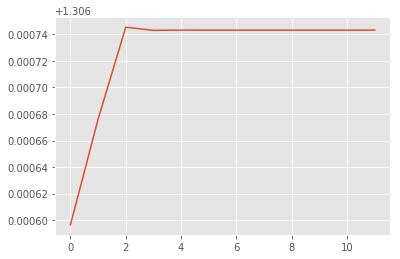

In [43]:
plt.plot(mc)

Text(0.5,1,'spectra 2 non-linear retrievel last step')

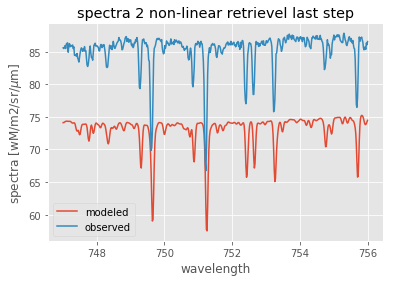

In [44]:

plt.plot(mySetup.wl_out,F_forward,label='modeled')
plt.plot(mySetup.wl_out,spectra2,label='observed')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 non-linear retrievel last step')

Text(0.5,1,'spectra 2 F_forward-F_observed')

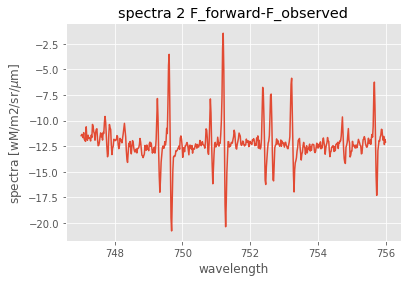

In [45]:
plt.plot(mySetup.wl_out,F_forward-spectra2)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 F_forward-F_observed')

In [46]:
np.array(ma)[:,-1]

array([-2.76329895, -2.76806256, -2.76874292, -2.76901455, -2.76900509,
       -2.76900581, -2.76900578, -2.76900578, -2.76900578, -2.76900578,
       -2.76900578, -2.76900578])

In [47]:

SIF = []; SIF_1SIGMA = [];CHI2_R = []
for i in range(100,102):
    for j in range(10,20):
        spectra = spectra_[i,:,j]
        _,K = forward_model_shift([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,compK=True)
        x_linear,sif_1sigma,chi2_r = linear_fit(spectra)
        #add prior info
        xa =[0,0,0,0.07,0,0,0,x_linear[-1]]#+list(x_linear[4:]) #[0,0,0,0,0,0,10]
        invSa = np.zeros((len(xa),len(xa)))
        invSa[-1,-1] = 1/(0.1**2)
        invSa[3,3] = 1/(0.008**2)
        ma,mb,mc =iterate_fit([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-10)
        SIF.append(ma[-1][-1])
        SIF_1SIGMA.append(mb[-1])
        CHI2_R.append(mc[-1])
        

LinAlgError: Singular matrix

In [48]:
SIF = np.reshape(np.array(SIF),(2,10))

ValueError: cannot reshape array of size 0 into shape (2,10)

TypeError: Invalid dimensions for image data

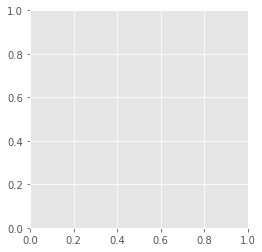

In [49]:
plt.imshow(np.array(SIF))
plt.colorbar()

In [50]:
SIF

[]

In [51]:
SIF

[]

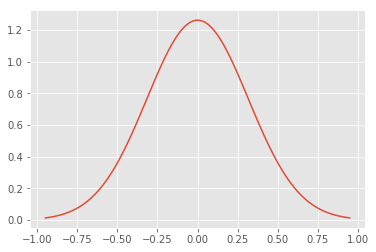

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

mu = 0
variance = 0.1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
test = mlab.normpdf(x, mu, sigma)
plt.plot(x,test)
plt.show()

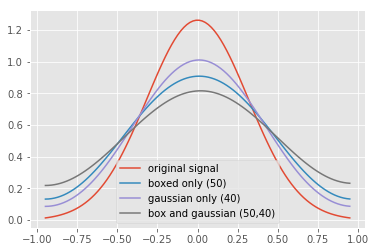

In [53]:
# test_box = np.convolve([0,1,1,1,1,1,1,1,0],test,mode='same')
test_box = uniform_filter1d(test,size=50)
test_gaussian = uniform_filter1d(test,40)
test_box_gaussian = uniform_filter1d(test_box,40)
plt.plot(x,test,label='original signal')
plt.plot(x,test_box,label='boxed only (50)')
plt.plot(x,test_gaussian,label='gaussian only (40)')
plt.plot(x,test_box_gaussian,label='box and gaussian (50,40)')

plt.legend()

In [54]:
x

array([-0.9486833 , -0.92951798, -0.91035266, -0.89118734, -0.87202202,
       -0.8528567 , -0.83369138, -0.81452606, -0.79536074, -0.77619543,
       -0.75703011, -0.73786479, -0.71869947, -0.69953415, -0.68036883,
       -0.66120351, -0.64203819, -0.62287287, -0.60370755, -0.58454223,
       -0.56537691, -0.5462116 , -0.52704628, -0.50788096, -0.48871564,
       -0.46955032, -0.450385  , -0.43121968, -0.41205436, -0.39288904,
       -0.37372372, -0.3545584 , -0.33539309, -0.31622777, -0.29706245,
       -0.27789713, -0.25873181, -0.23956649, -0.22040117, -0.20123585,
       -0.18207053, -0.16290521, -0.14373989, -0.12457457, -0.10540926,
       -0.08624394, -0.06707862, -0.0479133 , -0.02874798, -0.00958266,
        0.00958266,  0.02874798,  0.0479133 ,  0.06707862,  0.08624394,
        0.10540926,  0.12457457,  0.14373989,  0.16290521,  0.18207053,
        0.20123585,  0.22040117,  0.23956649,  0.25873181,  0.27789713,
        0.29706245,  0.31622777,  0.33539309,  0.3545584 ,  0.37

In [ ]:

SIF = []; SIF_1SIGMA = [];CHI2_R = []
for i in range(spectra_.shape[0]):
    print(i)
    for j in range(spectra_.shape[2]):
        spectra = spectra_[i,:,j]
        Forward,K = forward_model_shift([0,1,30]+[0.132,0.38,233.1,10],mySetup,compK=True)
        x_linear,sif_1sigma,chi2_r = linear_fit(spectra)
        SIF.append(x_linear[-1])
        SIF_1SIGMA.append(sif_1sigma)
        CHI2_R.append(chi2_r)
#         #add prior info
#         xa =[0,0,0,0.07,0,0,0,x_linear[-1]]#+list(x_linear[4:]) #[0,0,0,0,0,0,10]
#         invSa = np.zeros((len(xa),len(xa)))
#         invSa[-1,-1] = 1/(0.1**2)
#         invSa[3,3] = 1/(0.008**2)
#         ma,mb,mc =iterate_fit([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-10)
#         SIF.append(ma[-1][-1])
#         SIF_1SIGMA.append(mb[-1])
#         CHI2_R.append(mc[-1])
        

0


/home/rccheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in sqrt


1
2
3
4
5
6
7
8
9


/home/rccheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in true_divide


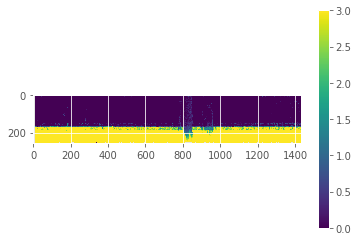

In [70]:
SIF = np.reshape(np.array(SIF),(spectra_.shape[0],spectra_.shape[2]))
plt.imshow(SIF,vmax=3,vmin=0)
plt.colorbar()

In [64]:
SIF

array([[         nan,          nan,          nan, ..., 100.26198368,
        105.78531245,  95.14236901],
       [ -2.84756581,          nan,          nan, ..., 120.4568195 ,
                 nan, 141.01913658],
       [ 28.31561521,          nan,          nan, ..., 108.18650785,
        118.72480445, 111.5053577 ],
       ...,
       [ 36.18508751,          nan,          nan, ...,  97.01525032,
        107.18338819,  87.32497627],
       [         nan,          nan,          nan, ..., 103.99648954,
        113.17989755,  91.70880612],
       [         nan,          nan,          nan, ..., 109.73352967,
        100.21395556, 125.58675652]])

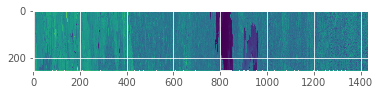

In [66]:
SIF_1SIGMA = np.reshape(np.array(SIF_1SIGMA),(spectra_.shape[0],spectra_.shape[2]))
plt.imshow(SIF_1SIGMA)

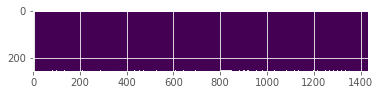

In [67]:
CHI2_R = np.reshape(np.array(CHI2_R),(spectra_.shape[0],spectra_.shape[2]))
plt.imshow(CHI2_R)

In [79]:
spectra_.shape

(256, 501, 1432)

In [63]:
SIF_n = []; SIF_1SIGMA_n = [];CHI2_R_n = []
for i in range(spectra_.shape[0]):
    print(i)
    for j in range(spectra_.shape[1]):
        spectra = spectra_[i,:,j]
        Forward,K = forward_model_shift([0,1,30]+[0.132,0.38,233.1,0],mySetup,compK=True)
        x_linear,sif_1sigma,chi2_r = linear_fit(spectra)
        #add prior info
        xa =[0,0,0,0,0,0,x_linear[-1]]#[0,0,0,0.07,0,0,0,x_linear[-1]]#+list(x_linear[4:]) #[0,0,0,0,0,0,10]
        invSa = np.zeros((len(xa),len(xa)))
        invSa[-1,-1] = 1/(0.1**2)
#         invSa[3,3] = 1/(0.008**2)
        ma,mb,mc =iterate_fit([0,1,40]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-10)
        print('sif',ma[-1][-1])
        SIF_n.append(ma[-1][-1])
        SIF_1SIGMA_n.append(mb[-1])
        CHI2_R_n.append(mc[-1])
        

0
[0, 0, 0, 0, 0, 0, nan]
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)


/home/rccheng/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:658: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/rccheng/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:659: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
n

/home/rccheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in sqrt


(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(

(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
sif nan
[0, 0, 0, 0, 0, 0, nan]
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)


(7,)
0.00679046013236
(7,)
0.00678337525357125
(7,)
0.006764421267959571
(7,)
0.006791212317792766
(7,)
0.006784530865743936
(7,)
0.006782220988771035
(7,)
0.006765436626078021
(7,)
0.006791019837767819
(7,)
0.006784385588041472
(7,)
0.006782467031506167
(7,)
0.006763797272104813
(7,)
0.0067906435315673004
(7,)
0.006784239502699461
(7,)
0.006781375241736947
(7,)
0.006770460830227074
(7,)
0.006791415258530295
(7,)
0.006781790675711713
(7,)
0.006794726595960482
(7,)
0.006788008575342881
(7,)
0.006780235833662792
(7,)
0.006803920724975783
(7,)
0.006786055200035643
(7,)
0.0067877577002711026
(7,)
0.006789428653188078
(7,)
0.006781211768759239
(7,)
0.0067721358021362674
(7,)
0.00678959507894232
(7,)
0.006778172651122209
(7,)
0.006790066568757837
(7,)
0.0067819259813392645
(7,)
0.006772152655449243
(7,)
0.006790964669793869
(7,)
0.006780504273253991
(7,)
0.006765657250865542
(7,)
0.006789508144760812
(7,)
0.006778744613054868
(7,)
0.006806579736776924
(7,)
0.0067856023935740665
(7,)
0.006794

(7,)
0.007270625801871268
(7,)
0.007714179199861864
(7,)
0.0069256028390243494
(7,)
0.0067987080149318375
(7,)
0.0067557441469372126
(7,)
0.006782222300334903
(7,)
0.006903340633137244
(7,)
0.006805857307168693
(7,)
0.006820990956900565
(7,)
0.006822883964950976
(7,)
0.006776276577634379
(7,)
0.006838852125975376
(7,)
0.006817028845689121
(7,)
0.00681667147127605
(7,)
0.006841531920948988
(7,)
0.006768885457228572
(7,)
0.006770947388070503
(7,)
0.0068812538061861755
(7,)
0.006770729121105235
(7,)
0.0069032269510865135
(7,)
0.006768595564664385
(7,)
0.006768376729198644
(7,)
0.006770641206327067
(7,)
0.006768948389691365
sif 149.70762878674512
[0, 0, 0, 0, 0, 0, 173.03042447327198]
(7,)
0.00683541577850753
(7,)
0.006834380382216532
(7,)
0.006815378950537417
(7,)
0.006812162021881813
(7,)
0.0068122829711727085
(7,)
0.006808914637468602
(7,)
0.006820500792246365
(7,)
0.006811381131744872
(7,)
0.006816337493706069
(7,)
0.006809987436954096
(7,)
0.00684486376038479
(7,)
0.006816059265891537

(7,)
0.006650046267391403
(7,)
0.006649714564060331
(7,)
0.006687008841735191
(7,)
0.006685958980688446
(7,)
0.006694010445246267
(7,)
0.006656006823268065
(7,)
0.0066503875217824035
(7,)
0.0066481375025562815
(7,)
0.006646856197495545
(7,)
0.006681521042368489
(7,)
0.006650114861863855
(7,)
0.006647763236710778
(7,)
0.006642362679325593
(7,)
0.006680395277730284
(7,)
0.006647461552561419
(7,)
0.0066475262824029395
(7,)
0.006690915413308644
(7,)
0.006656750988526331
(7,)
0.006650178359830348
(7,)
0.006650356837828123
(7,)
0.006694609157011622
(7,)
0.006651733484674766
(7,)
0.006649875861462797
(7,)
0.0066506870837025915
(7,)
0.006692921827039903
(7,)
0.006681566395644193
(7,)
0.006649429315346487
(7,)
0.006644267922113939
(7,)
0.006643109058710018
(7,)
0.00664957445086968
(7,)
0.006676544422198528
(7,)
0.006650258695588148
(7,)
0.00665049900084407
(7,)
0.006677521500631621
(7,)
0.006681290890527643
(7,)
0.006680655759999656
(7,)
0.006683927858964592
(7,)
0.006684302474125369
(7,)
0.006

(7,)
0.006524679374159838
(7,)
0.006526938498415168
(7,)
0.0065268455835315875
(7,)
0.006525441506494121
(7,)
0.006524138366878305
(7,)
0.006528448805008267
(7,)
0.006526190010994127
(7,)
0.006525675793091637
(7,)
0.006525539117636871
(7,)
0.006533793858928407
(7,)
0.0065272440953983765
(7,)
0.006525451223954153
(7,)
0.00652507750460692
(7,)
0.006524186349432652
(7,)
0.00652730780636612
(7,)
0.006524850220085081
(7,)
0.006527181400481101
(7,)
0.006526717774891412
(7,)
0.006532636264012535
(7,)
0.006528124097279133
(7,)
0.006526643751934242
(7,)
0.006524488886084709
(7,)
0.0065274530682948055
(7,)
0.006535711870585901
(7,)
0.0065269009057123345
(7,)
0.006526012581537117
(7,)
0.006526718030354391
(7,)
0.006524443206554409
(7,)
0.006527745792944605
(7,)
0.006524582872455187
(7,)
0.00652701252655218
(7,)
0.006526070130014169
(7,)
0.006527205733067507
(7,)
0.006524387913647342
(7,)
0.006528530788444468
(7,)
0.006526647169415686
(7,)
0.006524811408145298
(7,)
0.006527361134722957
(7,)
0.0065

(7,)
0.006567634242284557
(7,)
0.006577458309230378
(7,)
0.0066246618594498
(7,)
0.006558068149235832
(7,)
0.006586533393787371
(7,)
0.006537602196328223
(7,)
0.00660875160860903
(7,)
0.006526337207024493
(7,)
0.006529743024575193
(7,)
0.006521278271183758
(7,)
0.0065669303224410655
(7,)
0.006583780053536741
(7,)
0.006551431229836329
(7,)
0.006567723887512106
(7,)
0.0065941506786798805
(7,)
0.006622408065482568
(7,)
0.006612237710543939
(7,)
0.00657588484877571
(7,)
0.00661177152362386
(7,)
0.006595188876525138
(7,)
0.006599269643842521
(7,)
0.006569672056738283
(7,)
0.006674719614999929
(7,)
0.006556521624583413
(7,)
0.006706812745726807
(7,)
0.006568061930342476
(7,)
0.006704485652039865
(7,)
0.006557698255991819
(7,)
0.006573321728012138
(7,)
0.006530730421226548
(7,)
0.006522753416039076
(7,)
0.0065559373594715675
(7,)
0.006539179697564722
(7,)
0.006525706173448933
(7,)
0.006551408406247277
(7,)
0.006574224593294027
(7,)
0.006621806277918117
(7,)
0.006897241113005629
(7,)
0.0065493

(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(

(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
sif nan
[0, 0, 0, 0, 0, 0, 129.32218488654237]
(7,)
0.006491973925267259
(7,)
0.006528949364023991
(7,)
0.0065346818129137655
(7,)
0.006503739438382082
(7,)
0.006707240825967107
(7,)
0.006496796191822858
(7,)
0.006489370666671112
(7,)
0.006500206121338037
(7,)
0.006506748548780237
(7,)
0.006507971229972101
(7,)
0.006507146942327067
(7,)
0.006498114584771612
(7,)
0.00647967393577365
(7,)
0.006474962713509256
(7,)
0.006560644319095435
(7,)
0.006471631194788407
(7,)
0.006493965223829218
(7,)
0.006475256112050277
(7,)
0.006472337853871502
(7,)
0.006474065966900235
(7,)
0.006474227934875366
(7,)
0.006475013012854602
(7,)
0.00647553122931009
(7,)
0.00647551792108759
(7,)
0.006497141322897768
(7,)
0.006479815386131295
(7,)
0.006571043309332188
(7,)
0.006541205586746954
(7,)
0.006683485389049533
(7,)
0.006523150173268164
(7,)
0.006820375689398555
(7,)
0.007027850991976816
(7,)
0

(7,)
0.00642991354853233
(7,)
0.006427259769452742
(7,)
0.006431880440410949
(7,)
0.006432082667143467
(7,)
0.006439068813716534
(7,)
0.006435251534929375
(7,)
0.0064363405014672345
(7,)
0.006427593967972822
(7,)
0.006437391738994974
(7,)
0.006429145615733044
(7,)
0.006437882075895898
(7,)
0.0064392171306826606
(7,)
0.006431078952274879
(7,)
0.0064357291786568144
(7,)
0.0064326872404503
(7,)
0.006431986435043883
(7,)
0.006434546898523516
(7,)
0.0064399301637532765
(7,)
0.006442056178413105
(7,)
0.0064402468480987875
(7,)
0.00643393071591719
(7,)
0.006435453935506406
(7,)
0.006436282539919374
(7,)
0.006436638958217678
(7,)
0.006436113354211694
(7,)
0.006437109018070157
(7,)
0.006434539539903762
(7,)
0.006425903898488576
(7,)
0.0064326591402793
(7,)
0.0064270710690851555
(7,)
0.006432839009349727
(7,)
0.006432494899022745
(7,)
0.006446091994967989
(7,)
0.006448832114785188
(7,)
0.006437866673925033
(7,)
0.006430992248354621
(7,)
0.0064522068620004435
(7,)
0.0064455500736010155
(7,)
0.006

(7,)
0.006534816621336958
(7,)
0.006534876967109384
(7,)
0.006533528939634808
(7,)
0.006534793886138431
(7,)
0.006534327417335803
(7,)
0.006529797047157411
(7,)
0.006533191602634787
(7,)
0.006537893138299705
(7,)
0.006531896016312253
(7,)
0.006537766894217577
(7,)
0.006533144738689389
(7,)
0.006538912955896975
(7,)
0.006534637828041788
(7,)
0.0065307343289916844
(7,)
0.006539438921056528
(7,)
0.00653430465207821
(7,)
0.006534170679814711
(7,)
0.006534076774367041
(7,)
0.006534101194327738
(7,)
0.006534628582995273
(7,)
0.006529942428651974
(7,)
0.0065350615473054
(7,)
0.006532680528053712
(7,)
0.006534740364460005
(7,)
0.006533100141404775
(7,)
0.0065341865061890325
(7,)
0.006538127750913601
(7,)
0.006533996508783143
(7,)
0.006536910119571527
(7,)
0.006534483665017595
(7,)
0.006534844855859965
(7,)
0.006535094039769102
(7,)
0.00652992097553434
(7,)
0.006537821013038632
(7,)
0.006534643444432771
(7,)
0.006538526669092455
(7,)
0.006535307116057017
(7,)
0.006530256330956298
(7,)
0.0065389

(7,)
0.006350988929672983
(7,)
0.00635602673621477
(7,)
0.006357883782406995
(7,)
0.006356777468277274
(7,)
0.006346748787088578
(7,)
0.006349663425824235
(7,)
0.006354543612636442
(7,)
0.006351790966386709
(7,)
0.0063352242353462915
(7,)
0.006344237676518918
(7,)
0.006347214736639754
(7,)
0.006357289180230305
(7,)
0.006349453659923719
(7,)
0.006355117241302364
(7,)
0.006356469230700475
(7,)
0.006344072606566849
(7,)
0.006354422375192896
(7,)
0.0063567886586460495
(7,)
0.006355012009388183
(7,)
0.006350159316146253
(7,)
0.006354680458434291
(7,)
0.006363295587963344
(7,)
0.006369511195307575
(7,)
0.006350164775226044
(7,)
0.006354418250990131
(7,)
0.006392958202237642
(7,)
0.006358312162603316
(7,)
0.006359689525661741
(7,)
0.006367295569930947
(7,)
0.006365416375373215
(7,)
0.006360603282714217
(7,)
0.006361153087465674
(7,)
0.006366675095543103
(7,)
0.006349034168732284
(7,)
0.006347056029054076
(7,)
0.0063447435647185114
(7,)
0.006345253856741208
(7,)
0.0063533045377662046
(7,)
0.00

(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(

(7,)
0.006666608470820297
(7,)
0.006602397520953464
(7,)
0.006523707077399724
(7,)
0.006557713545447842
(7,)
0.006517660062659412
(7,)
0.006514938411930803
(7,)
0.006533178273679772
(7,)
0.006514904677423273
(7,)
0.006485933122952836
(7,)
0.006481394281432245
(7,)
0.006472994828843312
(7,)
0.006478627183554982
(7,)
0.0064687144987118535
(7,)
0.006469360967733364
(7,)
0.006471329549222722
(7,)
0.006504694599282747
(7,)
0.006587642916334675
(7,)
0.0064768534627993105
(7,)
0.006487085882569804
(7,)
0.006484695048795359
(7,)
0.0064817568564023015
(7,)
0.006474216239594155
(7,)
0.006621990515355849
(7,)
0.006519189804764677
(7,)
0.0065097653983404065
(7,)
0.006470551998290591
(7,)
0.006472167353317649
(7,)
0.006595686109007728
(7,)
0.006490767785057261
(7,)
0.006483892720906979
(7,)
0.0064737242196289835
(7,)
0.00647115792963664
(7,)
0.006472331235510699
(7,)
0.006596292164345518
(7,)
0.006478329659576908
(7,)
0.006480585794223172
(7,)
0.006484797629633819
(7,)
0.0067285003574332055
(7,)
0.

(7,)
0.00655568997555037
(7,)
0.00655980661889449
(7,)
0.006561662137387293
(7,)
0.006562977902748973
(7,)
0.006559162093262312
(7,)
0.006559236516058108
(7,)
0.006569420851125187
(7,)
0.006568415386535601
(7,)
0.0065588735375830595
(7,)
0.006558639113252113
(7,)
0.006557456180788592
(7,)
0.006555979957969088
(7,)
0.006560635277574824
(7,)
0.006556943380820502
(7,)
0.0065566760736518945
(7,)
0.006556706930414873
(7,)
0.006561686504906757
(7,)
0.006570808367141926
(7,)
0.006564385667963387
(7,)
0.006561674952339579
(7,)
0.006557848012002635
(7,)
0.0065658106922556435
(7,)
0.0065587749563941825
(7,)
0.006555180902606251
(7,)
0.006572919658114871
(7,)
0.006578138632044959
(7,)
0.00657428050292443
(7,)
0.0065731753420681886
(7,)
0.0065717626459664315
(7,)
0.006566486399857208
(7,)
0.006569099997898993
(7,)
0.006579275218716768
(7,)
0.006566553709557509
(7,)
0.006557957062228621
(7,)
0.006573133433384198
(7,)
0.00656323637885235
(7,)
0.006574566777913739
sif 146.1256291221055
[0, 0, 0, 0, 0

(7,)
0.006581089904669375
(7,)
0.006593758616748374
(7,)
0.006580159021075422
(7,)
0.00658321216691301
(7,)
0.006581129386073153
(7,)
0.006584718359653077
(7,)
0.006584034653700488
(7,)
0.006583926775399114
(7,)
0.006580459577867088
(7,)
0.0065804342228542026
(7,)
0.006584595850804874
(7,)
0.006583928770222653
(7,)
0.00658415034999847
(7,)
0.006581983475711965
(7,)
0.006583321243556521
(7,)
0.006586188962084141
(7,)
0.006583574680460438
(7,)
0.006580995295891274
(7,)
0.006584509490124979
(7,)
0.006585953536975323
(7,)
0.006583672683552025
(7,)
0.006582620785140827
(7,)
0.006584382734389222
(7,)
0.00658495636991398
(7,)
0.006583921299180411
(7,)
0.006584010525849609
(7,)
0.006584475261548861
(7,)
0.006585239152308854
(7,)
0.006583899854521001
(7,)
0.006585036965426465
(7,)
0.006583878692856589
(7,)
0.0065823811230976735
(7,)
0.0065822392865260496
(7,)
0.0065767617382255575
(7,)
0.00658148662642169
(7,)
0.006582094774593317
(7,)
0.006582957883355114
(7,)
0.006584111619420372
(7,)
0.00658

(7,)
0.006624543413375317
(7,)
0.006559886990184161
(7,)
0.006589034851798498
(7,)
0.0065854512359439865
(7,)
0.0065861702407986255
(7,)
0.006554727355203276
(7,)
0.006553964508130754
(7,)
0.0065668393509076125
(7,)
0.0065625919403822786
(7,)
0.006583050321389851
(7,)
0.006570357729591227
(7,)
0.006567150534853026
(7,)
0.006590781776258542
(7,)
0.006570475923732903
(7,)
0.006733259867261111
(7,)
0.006558918582510376
(7,)
0.006622317193628918
(7,)
0.006739284767185928
(7,)
0.006705545456512811
(7,)
0.007049215946908891
(7,)
0.006558188785736603
(7,)
0.006553689745067219
(7,)
0.006572941375135036
(7,)
0.006589742661560029
(7,)
0.006588757428367092
(7,)
0.006576936418542874
(7,)
0.006763007769844888
(7,)
0.006609365792754797
(7,)
0.00667274796164336
(7,)
0.006734422075750942
(7,)
0.00675157690628049
(7,)
0.0066370028808542345
(7,)
0.006565417037852443
(7,)
0.006569772807317155
(7,)
0.006582056338813376
(7,)
0.006712791068063599
(7,)
0.006848010798900275
(7,)
0.0071395119508056585
(7,)
0.0

(7,)
0.008672278757885283
(7,)
0.008866556519929462
(7,)
0.00833000850047413
(7,)
0.008662458209963154
(7,)
0.00837051769996282
(7,)
0.008779787312595188
(7,)
0.008367243813754463
(7,)
0.008687828880596367
(7,)
0.00825242750453298
(7,)
0.00866171471555738
(7,)
0.008230299301897379
(7,)
0.008676279366093475
(7,)
0.00822743856537845
(7,)
0.008612131427943884
(7,)
0.008287869828555134
(7,)
0.008742760155423837
(7,)
0.00825834762152411
(7,)
0.008657916270078397
(7,)
0.00824639690022055
(7,)
0.008659442019425406
(7,)
0.00826487778979431
(7,)
0.008769399135320599
(7,)
0.008341989827751818
(7,)
0.00867488876887009
(7,)
0.008224555513798573
(7,)
0.008669655040089142
(7,)
0.008229893297969028
(7,)
0.008586917684793234
(7,)
0.008100161570960334
(7,)
0.008355503380742427
(7,)
0.008859233653787114
(7,)
0.009031710157765173
(7,)
0.008275715696233752
(7,)
0.008587738278502994
(7,)
0.008578675953427648
(7,)
0.009344461591478849
(7,)
0.008270237281380795
(7,)
0.009147053938992847
(7,)
0.00898778385706

0.006538632296633881
(7,)
0.006529975046116297
(7,)
0.0065381342834791465
(7,)
0.006534298796265199
(7,)
0.006537012642733107
(7,)
0.006542838051127681
(7,)
0.006690116024501308
(7,)
0.006568858460904049
(7,)
0.006567891625665865
(7,)
0.006573397931498879
(7,)
0.006558157152627573
(7,)
0.006555479130558178
(7,)
0.006561271016701842
(7,)
0.006560826159306587
(7,)
0.006564924290842319
(7,)
0.006578072918490746
(7,)
0.0065650375458562405
(7,)
0.006578197436740268
(7,)
0.00654195353157604
(7,)
0.006538375220637801
(7,)
0.006540854994422973
(7,)
0.006549261807642663
(7,)
0.006538180325862606
(7,)
0.006607064108558714
(7,)
0.006570419232936289
(7,)
0.006539202738243894
(7,)
0.00655399336645737
(7,)
0.006538749539174266
(7,)
0.006644973324494766
(7,)
0.0065637159512395475
(7,)
0.006560003575499767
(7,)
0.006558914361864626
(7,)
0.006543624582531049
(7,)
0.006545665146394196
(7,)
0.006539322614328532
(7,)
0.006547342924881783
(7,)
0.006538669395924089
(7,)
0.0065441479083817086
(7,)
0.00658987

(7,)
0.006543316708056599
(7,)
0.006541072603489061
(7,)
0.006642125650369678
(7,)
0.006672556618488411
(7,)
0.006606779346074469
(7,)
0.006542559197732287
(7,)
0.0065387710935649514
(7,)
0.006547197385344551
(7,)
0.006540718339656744
(7,)
0.006547191686622426
(7,)
0.006614182050848824
(7,)
0.00654250667391763
(7,)
0.006540121124304196
(7,)
0.006548933336434131
(7,)
0.006557052173854752
(7,)
0.006543065115069711
(7,)
0.006542242307353674
(7,)
0.006530180722405189
(7,)
0.006529962219058439
(7,)
0.006530560494173517
(7,)
0.006531597483844297
(7,)
0.006531405369982416
(7,)
0.0065298760183415015
(7,)
0.006541718302868306
(7,)
0.006542421263172238
(7,)
0.00654340771684651
(7,)
0.006551842060018353
(7,)
0.006565148652865781
(7,)
0.006542453814266774
(7,)
0.0065419027457173946
(7,)
0.006536727971908145
(7,)
0.006532115456427024
(7,)
0.006533735470375697
(7,)
0.006652945584074411
(7,)
0.006541081830724193
(7,)
0.006541746005954074
(7,)
0.0065486203414158225
(7,)
0.006542897624914656
(7,)
0.006

(7,)
0.006382807792152871
sif 97.37970959961102
[0, 0, 0, 0, 0, 0, 111.27311983002043]
(7,)
0.00613065011143309
(7,)
0.006104467968437751
(7,)
0.00611299140068513
(7,)
0.006108023330751301
(7,)
0.006107140870725431
(7,)
0.006234054433393857
(7,)
0.006149391667731588
(7,)
0.006196286308257227
(7,)
0.0061402378252351005
(7,)
0.006174933017553513
(7,)
0.006866739642606911
(7,)
0.006157535978317227
(7,)
0.006409891277455529
(7,)
0.00629042297119784
(7,)
0.006144569617137423
(7,)
0.006159203630266943
(7,)
0.0061287707018530735
(7,)
0.00639166089931213
(7,)
0.006082716055026385
(7,)
0.006236221225758833
(7,)
0.007493958073076684
(7,)
0.006101195232182182
(7,)
0.006155676041012246
(7,)
0.006144323161589215
(7,)
0.006125751873959253
(7,)
0.0061036967593407505
(7,)
0.006125429225384267
(7,)
0.00615008234696127
(7,)
0.006114433444467533
(7,)
0.0061172871173430544
(7,)
0.006114617963594804
(7,)
0.006129657146884309
(7,)
0.006133541135017156
(7,)
0.006117712828882255
(7,)
0.00610496792850623
(7,)


(7,)
0.006426219850674484
(7,)
0.006433824462080628
(7,)
0.006508027017657555
(7,)
0.006612892245002987
(7,)
0.006619459008911023
(7,)
0.00641484159512121
(7,)
0.006413696798892496
(7,)
0.006378257284405059
(7,)
0.006334754252611126
(7,)
0.0063458166479528014
(7,)
0.0063586486365742895
(7,)
0.006335232924289536
(7,)
0.0063876807506441985
(7,)
0.006332990908914211
(7,)
0.006353892963850819
(7,)
0.006376495464368783
(7,)
0.006410373434834057
(7,)
0.006337270102409244
(7,)
0.006479102882204782
(7,)
0.006407734422158989
(7,)
0.0063883253945844105
(7,)
0.006359465966532508
(7,)
0.0063698702342158435
(7,)
0.0064271462491389784
(7,)
0.006360254907175457
(7,)
0.006387961167912114
(7,)
0.006358097289392357
(7,)
0.006356745980876551
(7,)
0.0063372942406692105
(7,)
0.006323866046344674
(7,)
0.006322826720331201
(7,)
0.0063970673938092085
(7,)
0.006393586939397829
(7,)
0.0063761619350524625
(7,)
0.006330426447034939
(7,)
0.006372321703242434
(7,)
0.006393823655977037
(7,)
0.00645844552354501
(7,)


(7,)
0.006492374949025764
(7,)
0.006468080623873941
(7,)
0.006449792799947921
(7,)
0.006477422129197109
(7,)
0.006494745731462451
(7,)
0.006472081826453137
(7,)
0.0064569828244802245
(7,)
0.006509864060337172
(7,)
0.006512335125475601
(7,)
0.006543213369962936
(7,)
0.006523553199043674
(7,)
0.006494270761734484
(7,)
0.006449633107559036
(7,)
0.006474160882069344
(7,)
0.006480187342020917
(7,)
0.006458739192976343
(7,)
0.006459176509105416
(7,)
0.006496152127335189
(7,)
0.006473721897048198
(7,)
0.006483233831439644
(7,)
0.006466185116189083
(7,)
0.006497593932826039
(7,)
0.006501282912105246
(7,)
0.00645904542301442
(7,)
0.006439548785802072
(7,)
0.006431485776774063
(7,)
0.006444878536651378
(7,)
0.006436221251123688
(7,)
0.006451125037725412
(7,)
0.006473116415058954
(7,)
0.0064324391019168654
(7,)
0.006435254662117257
(7,)
0.0064394635947812974
(7,)
0.006442183302526863
(7,)
0.006443486361325245
(7,)
0.006451699742068318
(7,)
0.0064415950589238125
(7,)
0.0064486164837292085
(7,)
0.0

(7,)
0.006561930506225672
(7,)
0.0065677376121222285
(7,)
0.006557730877637196
(7,)
0.0065627387010482
(7,)
0.006573807644425049
(7,)
0.006573598868015787
(7,)
0.006565080838791082
(7,)
0.006574314710383012
(7,)
0.0065728797943244805
(7,)
0.006564031552733752
(7,)
0.006574661109439691
(7,)
0.006566189353004474
(7,)
0.006567072747996669
(7,)
0.006556304008206872
(7,)
0.006560389767593084
(7,)
0.006566147219036834
(7,)
0.006570149980696933
(7,)
0.006560967961889193
(7,)
0.006563497198989445
(7,)
0.006555541449378027
(7,)
0.006569956526922946
(7,)
0.006559739819083261
(7,)
0.006562074455432633
(7,)
0.006562360768168516
(7,)
0.006568381648475019
(7,)
0.0065731350961446815
(7,)
0.006563571898358522
(7,)
0.006574218766447026
(7,)
0.00657219486572598
(7,)
0.006562287047926011
(7,)
0.0065702929446040705
(7,)
0.006567067828942015
(7,)
0.006564165567625378
(7,)
0.006568656820240417
(7,)
0.006557009590778902
(7,)
0.0065596305161678145
(7,)
0.006568489481339784
(7,)
0.00657306138858307
(7,)
0.0065

(7,)
0.006872565124974771
(7,)
0.006699454617575716
(7,)
0.006911459671243907
(7,)
0.006713501853682398
(7,)
0.00687535979704655
(7,)
0.0066974366458221486
(7,)
0.006911422560874264
(7,)
0.006710292157529366
(7,)
0.006863087481042432
(7,)
0.006695342794617601
(7,)
0.006911132634104983
(7,)
0.006715843611388758
(7,)
0.006875832205326297
(7,)
0.006700557571921214
(7,)
0.006915570193980391
(7,)
0.006717253428530251
(7,)
0.006851097037545904
(7,)
0.006704434459774868
(7,)
0.006916374712424662
(7,)
0.006725087961760153
(7,)
0.006861553391782645
(7,)
0.006700195730065807
(7,)
0.006903601929080593
(7,)
0.006706624449440573
(7,)
0.006871979131639011
(7,)
0.006689552733347808
(7,)
0.006904737392806277
(7,)
0.006711285719722693
(7,)
0.006888055543324127
(7,)
0.006706112812334037
(7,)
0.0069116644976956
(7,)
0.0067177193760189075
(7,)
0.006850688654104031
(7,)
0.006713636341352292
(7,)
0.0069005091269910964
(7,)
0.006702358305587435
(7,)
0.006883544233320834
(7,)
0.006692458172326069
(7,)
0.00689

(7,)
0.005995704982634245
(7,)
0.006013825707981859
(7,)
0.006011050362730876
(7,)
0.00601279263822732
(7,)
0.005983226995381474
(7,)
0.006004299128460474
(7,)
0.0060017305119002655
(7,)
0.006001877869274901
(7,)
0.00600396981201433
(7,)
0.005996197153813574
(7,)
0.0059989355263473845
(7,)
0.006000519511865459
(7,)
0.006003095459598372
(7,)
0.005998519185231166
(7,)
0.0059962087261779574
(7,)
0.0060010369715942525
(7,)
0.0059999733101213145
(7,)
0.0059965073603122756
(7,)
0.005996640836228106
(7,)
0.006014483296304914
(7,)
0.0060093852266801745
(7,)
0.005998103572150021
(7,)
0.006014674722661703
(7,)
0.00600436809389136
(7,)
0.006013791742407067
(7,)
0.006003966711511408
(7,)
0.005999819423270302
(7,)
0.006000100421696719
(7,)
0.005998973108973389
(7,)
0.005998947439162968
(7,)
0.006000670105869488
(7,)
0.005996698696209515
(7,)
0.0060079755196958875
(7,)
0.006099536384146507
(7,)
0.006000872634631137
(7,)
0.006088383707655462
(7,)
0.006001441328121661
(7,)
0.006029752589125755
(7,)
0.

(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(7,)
nan
(

KeyboardInterrupt: 

In [ ]:
SIF_n = np.reshape(np.array(SIF_n),(spectra_.shape[0],spectra_shape[2]))
plt.imshow(SIF_n)
SIF_1SIGMA_n = np.reshape(np.array(SIF_1SIGMA_n),(spectra_.shape[0],spectra_shape[2]))
plt.imshow(SIF_1SIGMA_n)
CHI2_R_n = np.reshape(np.array(CHI2_R_n),(spectra_.shape[0],spectra_shape[2]))
plt.imshow(CHI2_R_n)